Quantify class balance (overall + per split) and decide whether you need class weights / sampler / augmentation before training.

Imports + load splits

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path("..").resolve()
SPLITS_DIR = PROJECT_ROOT / "data/processed/ckplus/splits"

train_df = pd.read_csv(SPLITS_DIR / "train.csv")
val_df   = pd.read_csv(SPLITS_DIR / "val.csv")
test_df  = pd.read_csv(SPLITS_DIR / "test.csv")

for df in (train_df, val_df, test_df):
    df["path"] = df["path"].astype(str).str.strip()
    df["label_name"] = df["label_name"].astype(str).str.strip()

print(len(train_df), len(val_df), len(test_df))
train_df.head()

686 147 148


,path,label,label_name,width,height,mode,sha1
0,data/raw/ckplus/happy/S078_004_00000027.png,4,happy,48,48,L,b8cf9e957093b01e482005a1c47c514c72861e28
1,data/raw/ckplus/sadness/S080_005_00000011.png,5,sadness,48,48,L,54c7b1b5cf50c23cda4b4b6fe76fed4ffb639374
2,data/raw/ckplus/happy/S100_006_00000015.png,4,happy,48,48,L,5382e1c188577cb99e0d8c1c06f5551600ddb152
3,data/raw/ckplus/sadness/S138_007_00000009.png,5,sadness,48,48,L,9168e33c06eaf8bd31c87efb42c8e915604bfa3a
4,data/raw/ckplus/anger/S050_004_00000021.png,0,anger,48,48,L,ba8ea832e8c1feaf480996a441bafff3f172923b


Quick counts per split

In [2]:
def counts_by_class(df: pd.DataFrame) -> pd.Series:
    return df["label_name"].value_counts().sort_index()

train_counts = counts_by_class(train_df)
val_counts   = counts_by_class(val_df)
test_counts  = counts_by_class(test_df)

display(train_counts)
display(val_counts)
display(test_counts)

label_name
anger        94
contempt     38
disgust     124
fear         52
happy       145
sadness      59
surprise    174
Name: count, dtype: int64

label_name
anger       20
contempt     8
disgust     26
fear        12
happy       31
sadness     13
surprise    37
Name: count, dtype: int64

label_name
anger       21
contempt     8
disgust     27
fear        11
happy       31
sadness     12
surprise    38
Name: count, dtype: int64

Combine into one table

In [3]:
counts_tbl = pd.DataFrame({
    "train": train_counts,
    "val": val_counts,
    "test": test_counts,
}).fillna(0).astype(int)

counts_tbl["total"] = counts_tbl.sum(axis=1)
counts_tbl.loc["__TOTAL__"] = counts_tbl.sum(axis=0)

counts_tbl

,train,val,test,total
label_name,,,,
anger,94,20,21,135
contempt,38,8,8,54
disgust,124,26,27,177
fear,52,12,11,75
happy,145,31,31,207
sadness,59,13,12,84
surprise,174,37,38,249
__TOTAL__,686,147,148,981


Plot class distribution (per split)

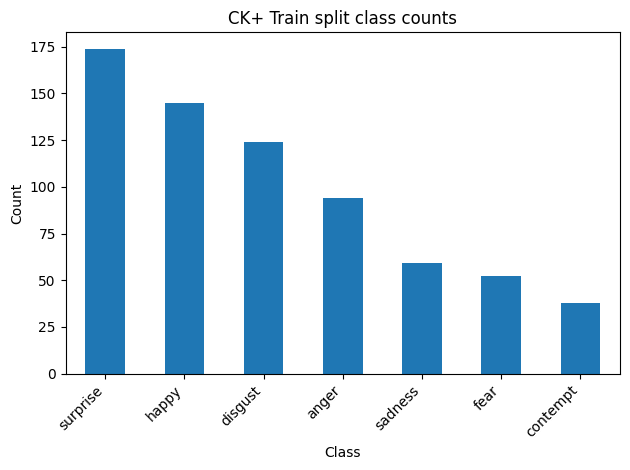

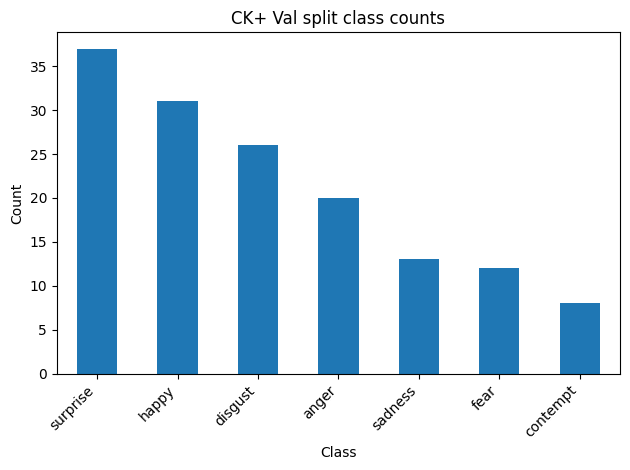

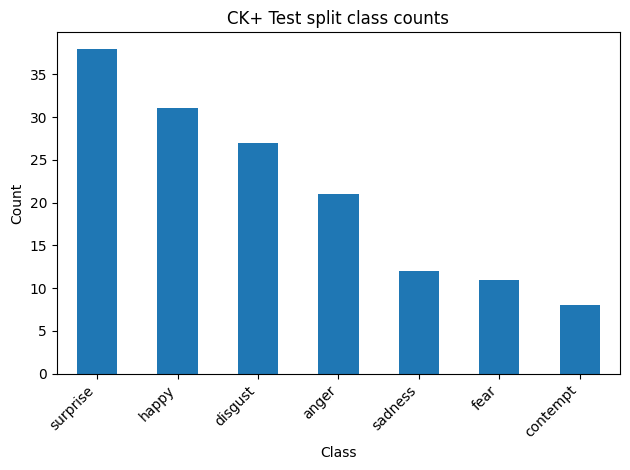

In [4]:
def plot_counts(series: pd.Series, title: str):
    plt.figure()
    series.sort_values(ascending=False).plot(kind="bar")
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_counts(train_counts, "CK+ Train split class counts")
plot_counts(val_counts,   "CK+ Val split class counts")
plot_counts(test_counts,  "CK+ Test split class counts")

Imbalance metrics to help decide what to do next

Rule of thumb:

- ratio < 2: usually fine
- ratio 2–5: consider class weights + augmentation
- ratio > 5: definitely address imbalance

In [6]:
def imbalance_stats(counts: pd.Series) -> dict:
    counts = counts[counts > 0]
    mx = int(counts.max())
    mn = int(counts.min())
    ratio = float(mx / mn) if mn > 0 else float("inf")
    return {
        "num_classes_present": int(counts.size),
        "min_count": mn,
        "max_count": mx,
        "max_to_min_ratio": ratio,
        "total": int(counts.sum()),
    }

print("Train:", imbalance_stats(train_counts))
print("Val:  ", imbalance_stats(val_counts))
print("Test: ", imbalance_stats(test_counts))

Train: {'num_classes_present': 7, 'min_count': 38, 'max_count': 174, 'max_to_min_ratio': 4.578947368421052, 'total': 686}
Val:   {'num_classes_present': 7, 'min_count': 8, 'max_count': 37, 'max_to_min_ratio': 4.625, 'total': 147}
Test:  {'num_classes_present': 7, 'min_count': 8, 'max_count': 38, 'max_to_min_ratio': 4.75, 'total': 148}


**Based on the numbers, we'll have to use class weights and some augmentation to balance the classes.**

Are splits roughly stratified? stratified splitting was used, so class proportions should be similar

In [10]:
# Percentage
def proportions(counts: pd.Series) -> pd.Series:
    counts = counts.fillna(0)
    return (counts / counts.sum()).sort_index()

prop_tbl = pd.DataFrame({
    "train": proportions(train_counts),
    "val": proportions(val_counts),
    "test": proportions(test_counts),
}).fillna(0)

prop_tbl

,train,val,test
label_name,,,
anger,0.137026,0.136054,0.141892
contempt,0.055394,0.054422,0.054054
disgust,0.180758,0.176871,0.182432
fear,0.075802,0.081633,0.074324
happy,0.211370,0.210884,0.209459
sadness,0.086006,0.088435,0.081081
surprise,0.253644,0.251701,0.256757


<Figure size 640x480 with 0 Axes>

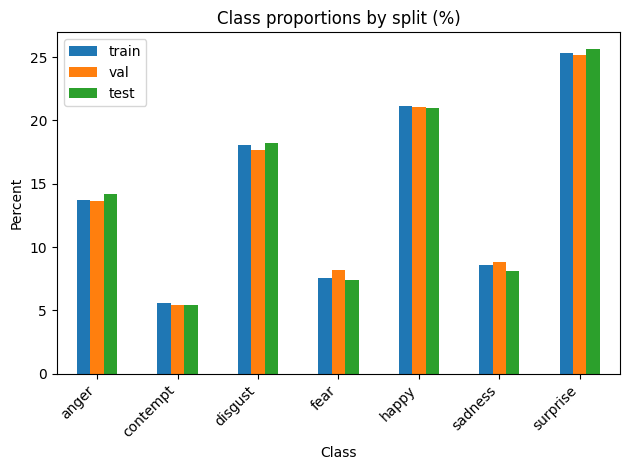

In [9]:
plt.figure()
(prop_tbl * 100).plot(kind="bar")
plt.title("Class proportions by split (%)")
plt.xlabel("Class")
plt.ylabel("Percent")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Save the results of the checks of this notebook to a CSV file.

In [ ]:
import json

PROJECT_ROOT = Path("..").resolve()
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts/reports/eda"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

def counts_by_class(df: pd.DataFrame) -> pd.Series:
    return df["label_name"].value_counts().sort_index()

def proportions(counts: pd.Series) -> pd.Series:
    total = counts.sum()
    return (counts / total) if total > 0 else counts * 0.0

def imbalance_stats(counts: pd.Series) -> dict:
    counts = counts[counts > 0]
    mx = int(counts.max()) if len(counts) else 0
    mn = int(counts.min()) if len(counts) else 0
    ratio = float(mx / mn) if mn > 0 else float("inf")
    return {
        "num_classes_present": int(len(counts)),
        "min_count": mn,
        "max_count": mx,
        "max_to_min_ratio": ratio,
        "total": int(counts.sum()),
    }

# --- counts tables ---
train_counts = counts_by_class(train_df)
val_counts   = counts_by_class(val_df)
test_counts  = counts_by_class(test_df)

all_classes = sorted(set(train_counts.index) | set(val_counts.index) | set(test_counts.index))

counts_tbl = pd.DataFrame({
    "train": train_counts.reindex(all_classes),
    "val":   val_counts.reindex(all_classes),
    "test":  test_counts.reindex(all_classes),
}).fillna(0).astype(int)
counts_tbl["total"] = counts_tbl.sum(axis=1)

prop_tbl = pd.DataFrame({
    "train": proportions(counts_tbl["train"]),
    "val":   proportions(counts_tbl["val"]),
    "test":  proportions(counts_tbl["test"]),
}).fillna(0.0)

# --- stratification consistency (max deviation in percentage points) ---
max_dev_pp = float(((prop_tbl.max(axis=1) - prop_tbl.min(axis=1)) * 100.0).max())

# --- simple recommendations ---
train_ratio = imbalance_stats(counts_tbl["train"])["max_to_min_ratio"]
recommendations = {
    "weighted_sampler": train_ratio >= 2.0,
    "class_weights": train_ratio >= 4.0, 
    "augmentation": True,
    "note": "Start with WeightedRandomSampler + mild aug. Add class-weighted loss if minority-class recall is still poor."
}

# --- integrity issues ---
issues = []
expected_num_classes = 7  # adjust if needed
for split_name, c in [("train", counts_tbl["train"]), ("val", counts_tbl["val"]), ("test", counts_tbl["test"])]:
    present = int((c > 0).sum())
    if present != expected_num_classes:
        missing = [cls for cls in all_classes if int(c.loc[cls]) == 0]
        issues.append(f"{split_name} has {present}/{expected_num_classes} classes. Missing: {missing}")

report = {
    "dataset": "ckplus",
    "classes": all_classes,
    "splits": {
        "train": imbalance_stats(counts_tbl["train"]),
        "val":   imbalance_stats(counts_tbl["val"]),
        "test":  imbalance_stats(counts_tbl["test"]),
    },
    "max_proportion_deviation_pp": max_dev_pp,
    "recommendations": recommendations,
    "issues": issues,
}

# --- save artifacts ---
counts_tbl.to_csv(ARTIFACTS_DIR / "notebook01_class_counts.csv")
prop_tbl.to_csv(ARTIFACTS_DIR / "notebook01_class_proportions.csv")
with open(ARTIFACTS_DIR / "notebook01_class_balance_report.json", "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2)

print("Saved report artifacts to:", ARTIFACTS_DIR)
report


Saved report artifacts to: D:\Kebench\Documents\projects\xai-lab\artifacts\reports\eda


{'dataset': 'ckplus',
 'classes': ['anger',
  'contempt',
  'disgust',
  'fear',
  'happy',
  'sadness',
  'surprise'],
 'splits': {'train': {'num_classes_present': 7,
   'min_count': 38,
   'max_count': 174,
   'max_to_min_ratio': 4.578947368421052,
   'total': 686},
  'val': {'num_classes_present': 7,
   'min_count': 8,
   'max_count': 37,
   'max_to_min_ratio': 4.625,
   'total': 147},
  'test': {'num_classes_present': 7,
   'min_count': 8,
   'max_count': 38,
   'max_to_min_ratio': 4.75,
   'total': 148}},
 'max_proportion_deviation_pp': 0.7354293068578779,
 'recommendations': {'weighted_sampler': True,
  'class_weights': True,
  'augmentation': True,
  'note': 'Start with WeightedRandomSampler + mild aug. Add class-weighted loss if minority-class recall is still poor.'},
 'issues': []}